In [104]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        ak = os.path.join(dirname, filename)

print('None')
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

None


In [2]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as T
from torchvision import datasets, models
from torch.utils.data import DataLoader, TensorDataset

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [4]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [6]:
features_vector = []

# Data Augmentation
transform_pipeline = T.Compose([
    T.Resize((244, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.RandomAffine(10),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
train_root = "/kaggle/input/flower-image-dataset/flowers/"

In [8]:
def counting_files_in_folder(data_path)->None:
    print(f"Files in folder path ({train_root}) : {len(os.listdir(data_path))} files")

In [9]:
counting_files_in_folder(train_root)

Files in folder path (/kaggle/input/flower-image-dataset/flowers/) : 733 files


In [10]:
class_names = []

for filename in os.listdir(train_root):
    if filename.endswith(".jpg"):  
        class_name = filename.split("_")[0]  
        class_names.append(class_name)

unique_classes = set(class_names)

print(f"Total of Class: {len(unique_classes)}")
print("Class Found:", unique_classes)

Total of Class: 10
Class Found: {'peonies', 'daisies', 'garden', 'gardenias', 'hydrangeas', 'orchids', 'hibiscus', 'lilies', 'bougainvillea', 'tulip'}


In [11]:
my_data = []

for i in os.listdir(train_root):
    img_path = os.path.join(train_root, i)
    with Image.open(img_path) as image:
        image = image.convert("RGB")
        image_T = transform_pipeline(image)
        my_data.append(image_T.unsqueeze(0))  

data = torch.cat(my_data, dim=0).to(device)
print(data.shape)


torch.Size([733, 3, 244, 224])


In [12]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(data, test_size=0.3, random_state=42)

In [13]:
train_dataset = TensorDataset(train_data)
val_dataset = TensorDataset(val_data)

dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [14]:
model = models.efficientnet_b7(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b7_lukemelas-c5b4e57e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b7_lukemelas-c5b4e57e.pth
100%|██████████| 255M/255M [00:01<00:00, 204MB/s] 


In [15]:
# Layer Freeze
for p in model.parameters():
    p.requires_grad = False
    
num_classes = 10
model.classifier = nn.Sequential(
    nn.Dropout(p=0.3),
    nn.Linear(model.classifier[1].in_features, num_classes)
)

In [16]:
from tqdm import tqdm

In [17]:
def train_model(model, dataloader, val_dataloader, optimizer, criterion, device, epochs=10):
    model.to(device)
    feature_list = []
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        pbar = tqdm(dataloader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for batch in pbar:
            
            if isinstance(batch, (list, tuple)):
                inputs = batch[0]
            else:
                inputs = batch

            inputs = inputs.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, outputs)  
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            feature_list.append(outputs.detach().cpu().numpy())

        train_losses.append(running_loss / len(dataloader))

        # Validation loop (optional)
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_dataloader:
                inputs = batch[0].to(device) if isinstance(batch, (list, tuple)) else batch.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, outputs)
                val_loss += loss.item()
        val_losses.append(val_loss / len(val_dataloader))

    feature_array = np.concatenate(feature_list, axis=0)
    return feature_array, train_losses, val_losses

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.classifier.parameters(), lr=5e-4, weight_decay=1e-6)

In [19]:
feature_array, train_losses, val_losses = train_model(
    model=model,
    dataloader=dataloader,
    val_dataloader=val_dataloader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    epochs=10
)

In [22]:
import matplotlib.pyplot as plt

In [25]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.legend()
    plt.show()

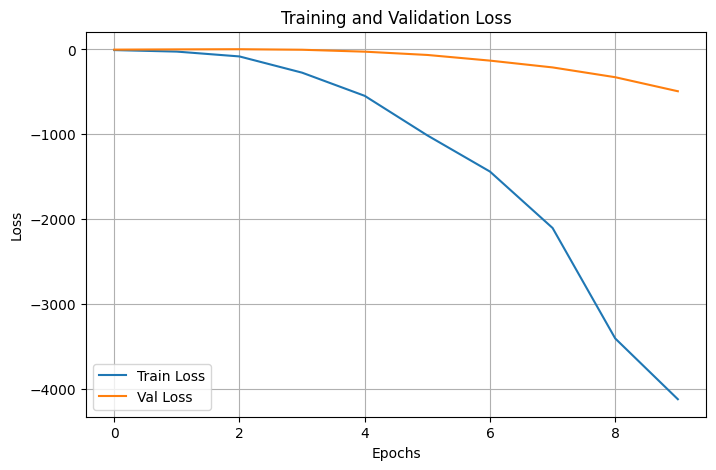

In [26]:
plot_losses(train_losses, val_losses)

In [27]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:8

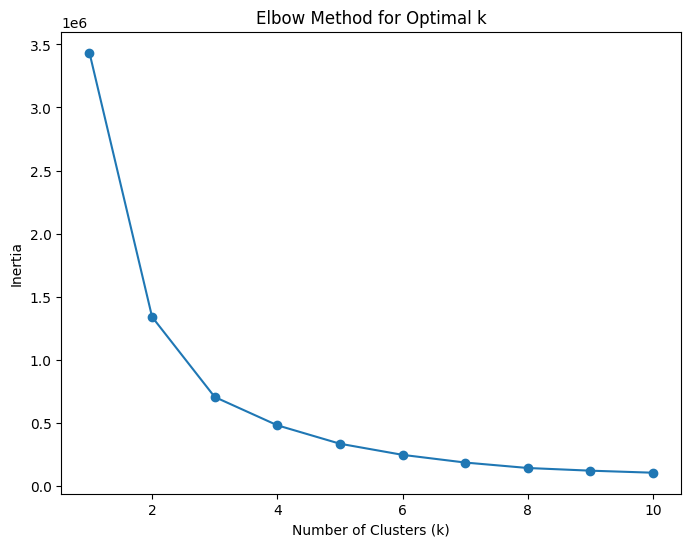

In [29]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(feature_array)
    inertia.append(kmeans.inertia_)

# วาดกราฟ Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

In [42]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(feature_array)

In [43]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(pca_result)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


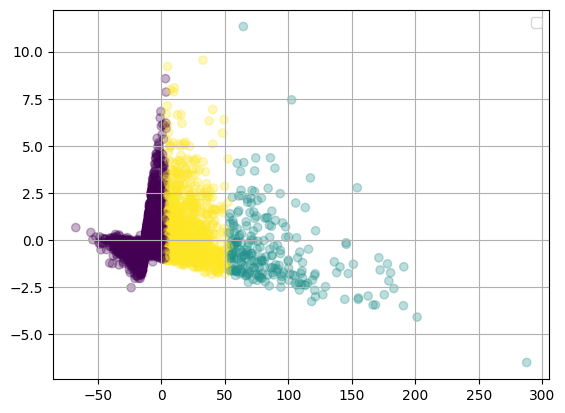

In [44]:
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, cmap='viridis', alpha=0.3)
plt.legend()
plt.grid(True)
plt.show()

In [45]:
print(f'PCA + KMeans Score: {silhouette_score(pca_result, labels)}')

PCA + KMeans Score: 0.6389957070350647


In [109]:
from mpl_toolkits.mplot3d import Axes3D

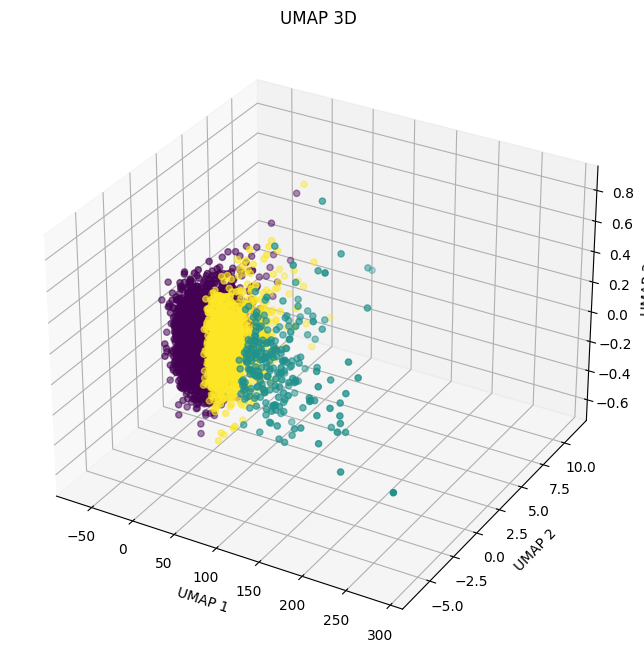

In [110]:
pca = PCA(n_components=3)
reduced = pca.fit_transform(feature_array)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced[:, 0], reduced[:, 1], reduced[:, 2], c=labels, cmap='viridis')
ax.set_title('UMAP 3D')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')
ax.set_zlabel('UMAP 3')
plt.show()

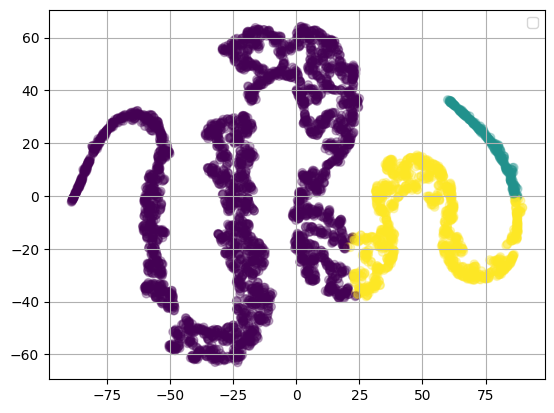

In [78]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(pca_result)

plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=labels, cmap='viridis', alpha=0.3)
plt.legend()
plt.grid(True)
plt.show()

In [80]:
unique, counts = np.unique(labels, return_counts=True)
cluster_counts = pd.DataFrame({'Cluster': unique, 'Count': counts})
print(cluster_counts)

   Cluster  Count
0        0   3754
1        1    239
2        2   1137


In [88]:
def show_images_by_cluster(images, labels, cluster_id, n=10):
    images = images.cpu().numpy() if hasattr(images, 'cpu') else images
    idxs = np.where(labels == cluster_id)[0][:n]

    plt.figure(figsize=(15, 3))
    for i, idx in enumerate(idxs):
        img = images[idx]
        if img.shape[0] == 3: 
            img = np.transpose(img, (1, 2, 0))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle(f"Cluster {cluster_id}")
    plt.show()

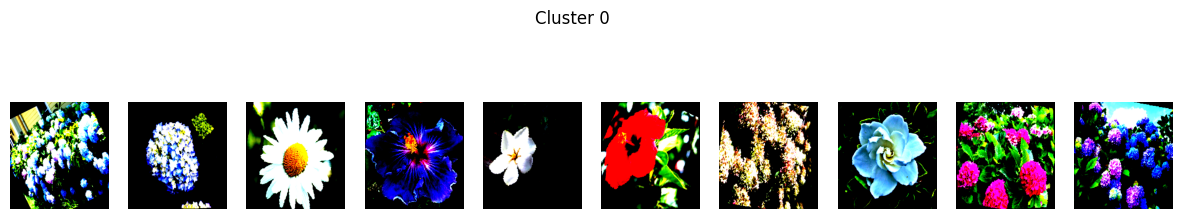

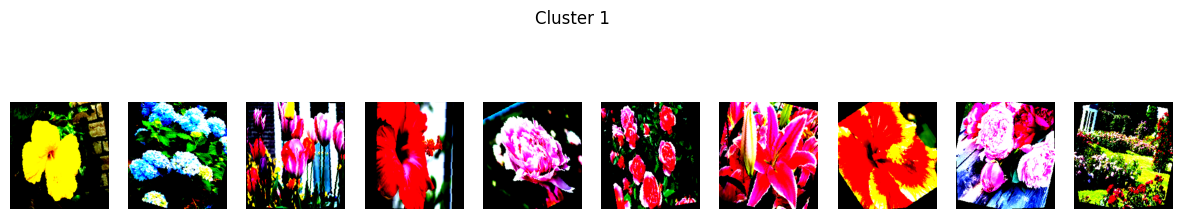

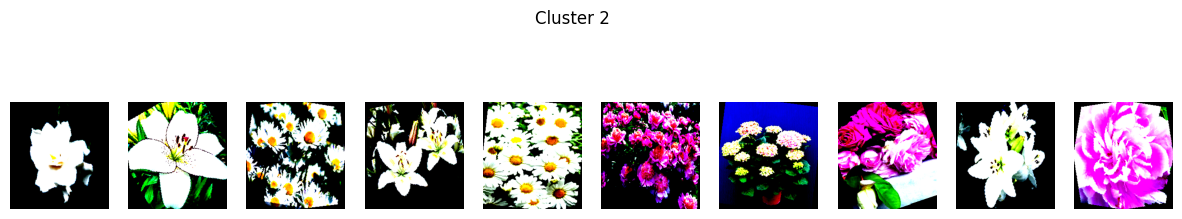

In [90]:
train_labels, val_labels = train_test_split(labels, test_size=0.3, random_state=42)

images = train_dataset.tensors[0]
for cluster_id in range(kmeans.n_clusters):
    show_images_by_cluster(images, train_labels, cluster_id)

In [100]:
means = []
stds = []

for cluster_id in range(kmeans.n_clusters):
    cluster_data = train_data[train_labels == cluster_id]  
    std = torch.std(cluster_data.float(), dim=0)
    
    means.append(mean.cpu().numpy())  
    stds.append(std.cpu().numpy())

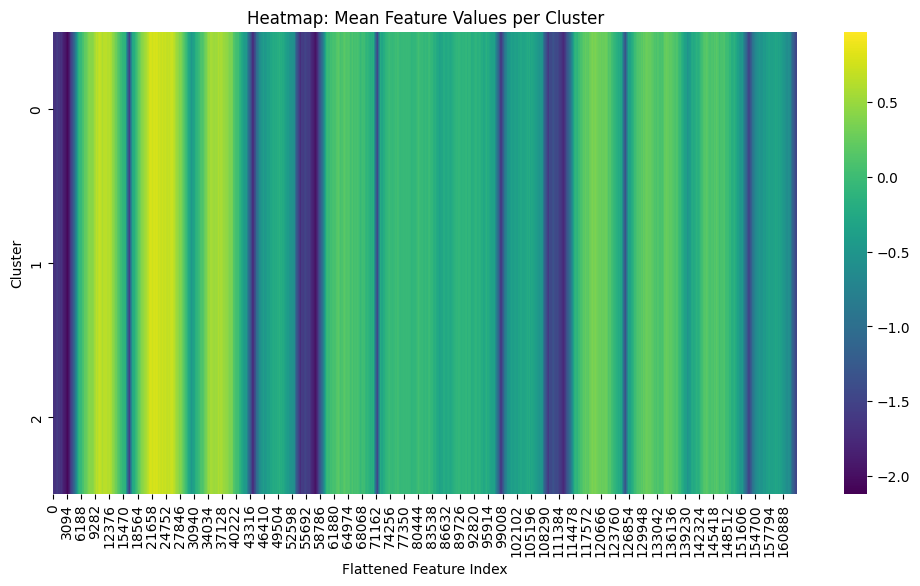

In [111]:
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.heatmap(means.reshape(kmeans.n_clusters, -1), cmap='viridis', annot=False)
plt.xlabel("Flattened Feature Index")
plt.ylabel("Cluster")
plt.title("Heatmap: Mean Feature Values per Cluster")
plt.show()